In [1]:
# import prepared data
from prepare_zillow import prepare_zillow_without_outliers
from summarize import df_summary

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Wrangling
import numpy as np
import pandas as pd

# Visualizing
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import plotly.plotly as py
import plotly.tools as tls
import cufflinks as cf
print('cufflinks version ', cf.__version__)
import plotly.graph_objs as go
import sys # used in command to make entire array print by default

# Modeling
from scipy.spatial.distance import cdist
from scipy.cluster.vq import kmeans2, whiten
from sklearn.cluster import KMeans
from sklearn import metrics
import math
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
from scipy import stats
from pandas.tools.plotting import scatter_matrix
from matplotlib.ticker import FormatStrFormatter
from sklearn.linear_model import LinearRegression
from matplotlib.figure import Figure
from sklearn.cluster import KMeans

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std


# Though the following import is not directly being used, it is required
# for 3D projection to work
from mpl_toolkits.mplot3d import Axes3D
pd.options.display.float_format = '{:20,.2f}'.format

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# import os
# import sys

cufflinks version  0.15


In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# makes entire array print by default, can add [:##] to end to set length
np.set_printoptions(threshold=sys.maxsize)

In [4]:
df = prepare_zillow_without_outliers()
df.sample(3)
# Kept only the single unit properties, per Michael's function.
# Dropped columns with more than 45% data missing in a column
# and dropped rows with more than 25% data missing in the row.
# Filled missing calculatedbathnbr and fullbathcnt with bathroomcnt
# then went back and dropped all rows with ANY missing values.
# Converted the datatypes of the numeric columns to int and category as appropriate.

Reading Zillow data...
Preparing and cleaning Zillow data...
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)
[33039.95776043]
[[-0.00962733]]
Univariate - final_exam = b + m * exam1
    y-intercept (b): 33039.96
    coefficient (m): -0.01

Zillow data is now ready for analysis!


,logerror,bath,bed,bedbath,totsqft,finsqft,year,land_tax_val,struct_tax_val,land_struct_tax_val,...,lotsize,bldgqualtype,hvac,landusecode,landusedesc,propzone,rawcensus,census,assessmentyr,transdate
parcelid,,,,,,,,,,,,,,,,,,,,,
12603480,0.01,0.22,0.20,0.42,0.12,0.12,0.93,0.15,0.04,0.18,...,0.02,4.00,Central,010D,Planned Unit Development,TOPR-MD,60376509,60376509023009,2015,2016-07-22
11069345,-0.03,0.22,0.30,0.52,0.18,0.18,0.93,0.21,0.04,0.24,...,0.00,4.00,Central,010D,Planned Unit Development,LARZ4,60371082,60371082021028,2015,2016-08-12
11853596,0.17,0.22,0.20,0.42,0.11,0.11,0.72,0.08,0.03,0.10,...,0.00,8.00,Central,010D,Planned Unit Development,PRPUD*,60375005,60375005001018,2016,2017-08-08


In [5]:
def encode_col(df, cols):
    for col in cols:
        encoder = LabelEncoder()
        encoder.fit(df[col])
        df[col] = encoder.transform(df[col])
    return encoder, df

encoder, df_features = encode_col(df, cols=['hvac', 'landusecode', 'landusedesc', 'propzone', 'transdate'])
df_features.head()

,logerror,bath,bed,bedbath,totsqft,finsqft,year,land_tax_val,struct_tax_val,land_struct_tax_val,...,lotsize,bldgqualtype,hvac,landusecode,landusedesc,propzone,rawcensus,census,assessmentyr,transdate
parcelid,,,,,,,,,,,,,,,,,,,,,
11016594,0.03,0.11,0.20,0.31,0.10,0.10,0.59,0.09,0.02,0.11,...,0.00,4.00,0,1,5,666,60371066,60371066461001,2015,0
12098116,-0.00,0.22,0.10,0.32,0.14,0.14,0.45,0.02,0.01,0.03,...,0.01,4.00,0,1,5,1620,60374638,60374638003004,2015,0
12643413,0.02,0.11,0.10,0.21,0.03,0.03,0.79,0.03,0.02,0.05,...,0.04,4.00,0,9,0,643,60372963,60372963002002,2015,1
11509835,-0.27,0.33,0.30,0.63,0.21,0.21,0.75,0.63,0.12,0.75,...,0.00,1.00,0,1,5,564,60376210,60376210044006,2015,1
12286022,0.04,0.00,0.10,0.10,0.07,0.07,0.44,0.02,0.01,0.03,...,0.00,7.00,1,1,5,285,60375416,60375416053007,2015,1


In [6]:
df_features.drop(columns=['landusedesc', 'hvac', 'assessmentyr', 'landusecode', 'bedbath', 'rawcensus',
                          'census', 'tax_val', 'propzone', 'land_struct_tax_val', 'finsqft'], 
                 inplace=True)

In [7]:
num_cols = df_features.select_dtypes(include='number').columns.tolist()
cat_cols = df_features.select_dtypes(exclude='number').columns.tolist()

### cluster 1 -- logerror only

In [8]:
kmeans = KMeans(n_clusters=4) 
kmeans.fit(df_features[['logerror']])
df_features['cluster_target_A'] = kmeans.predict(df_features[['logerror']])
df_features.cluster_target_A = (df_features.cluster_target_A + 1)

### cluster 2 -- totsqft only

In [9]:
kmeans = KMeans(n_clusters=4) 
kmeans.fit(df_features[['totsqft']])
df_features['cluster_target_B'] = kmeans.predict(df_features[['totsqft']])
df_features.cluster_target_B = (df_features.cluster_target_B + 1)

### cluster 3 -- land_tax_val only

In [10]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_features[['land_tax_val']])
df_features['cluster_target_C'] = kmeans.predict(df_features[['land_tax_val']])
df_features.cluster_target_C = (df_features.cluster_target_C + 1)

### cluster 4 -- latitude, longitude, and totsqft

In [11]:
kmeans = KMeans(n_clusters=4)
kmeans.fit(df_features[['latitude', 'longitude', 'totsqft']])
df_features['cluster_target_D'] = kmeans.predict(df_features[['latitude', 'longitude', 'totsqft']])
df_features.cluster_target_D = (df_features.cluster_target_D + 1)

### cluster 5 -- lotsize

In [12]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df_features[['lotsize']])
df_features['cluster_target_E'] = kmeans.predict(df_features[['lotsize']])
df_features.cluster_target_E = (df_features.cluster_target_E + 1)

In [13]:
df_features[['logerror', 'totsqft', 'land_tax_val', 'struct_tax_val', 'year', 'cluster_target_A', 
             'cluster_target_B', 'cluster_target_C', 'cluster_target_D', 'cluster_target_E']].sample(10)

,logerror,totsqft,land_tax_val,struct_tax_val,year,cluster_target_A,cluster_target_B,cluster_target_C,cluster_target_D,cluster_target_E
parcelid,,,,,,,,,,
10958655,0.03,0.08,0.21,0.02,0.45,1,1,3,2,1
11513416,-0.11,0.07,0.24,0.02,0.74,1,1,2,3,1
13086284,0.03,0.10,0.06,0.02,0.73,1,2,1,1,2
12554336,0.01,0.05,0.05,0.02,0.75,1,1,1,3,1
12544040,0.06,0.13,0.18,0.03,0.27,1,2,3,3,1
10821963,0.01,0.05,0.12,0.01,0.51,1,1,3,2,1
11808521,0.05,0.04,0.04,0.01,0.93,1,1,1,3,1
11744481,-0.00,0.10,0.11,0.01,0.22,1,2,3,3,1
12849859,-0.01,0.04,0.04,0.01,0.58,1,1,1,1,1


### Train and Test Split

In [14]:
def validate_train_test_split(X_train, y_train, X_test, y_test, train, test):
    if X_train.shape[0] == y_train.shape[0]:
        print("X & y train rows ARE equal")
    else:
        print("X & y train rows ARE NOT equal")


    if X_test.shape[0] == y_test.shape[0]:
        print("X & y test rows ARE equal")
    else:
        print("X & y test rows ARE NOT equal")

    if train.shape[1] == test.shape[1]:
        print("Number of columns in train & test ARE equal")
    else:
        print("Number of columns in train & test ARE NOT equal")

    train_split = train.shape[0] / (train.shape[0] + test.shape[0])
    test_split = test.shape[0] / (train.shape[0] + test.shape[0])

    print("Train Split: %.2f" % train_split)
    print("Test Split: %.2f" % test_split)

In [15]:
# train_test_split
X = df.drop(['logerror'], axis=1)
y = df[['logerror']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=0)

train = pd.concat([X_train, y_train], axis=1)

test = pd.concat([X_test, y_test], axis=1)

In [16]:
validate_train_test_split(X_train, y_train, X_test, y_test, train, test)

X & y train rows ARE equal
X & y test rows ARE equal
Number of columns in train & test ARE equal
Train Split: 0.80
Test Split: 0.20


Use statsmodels ordinary least squares to assess the importance of each feature with respect to the target.

In [17]:
# Could not get this to work...
# ols_model = sm.OLS(y_train, X_train)
# fit = ols_model.fit()
# fit.summary()

#### Summarize your conclusions and next steps from your analysis in above.¶
What will you try when developing your model? (which features to use/not use/etc)

If the data is good for modeling, then our residuals will have certain characteristics. These characteristics are:

1. The data is “linear”. That is, the dependent variable is a linear function of independent variables and an error term e, and is largely dependent on characteristics 2-4. Think of the equation of a line in two dimensions: y = mx + b + e. yis the dependent or “response” variable, xis the input, mis the dimensional coefficient and bis the intercept (when x = 0). We can easily extend this “line” to higher dimensions by adding more inputs and coefficients, creating a hyperplane with the following form: y = a1*x1+ a2*x2+ … + an*xn
2. Errors are normally distributed across the data. In other words, if you plotted the errors on a graph, they should take on the traditional bell-curve or Gaussian shape.
3. There is “homoscedasticity”. This means that the variance of the errors is consistent across the entire dataset. We want to avoid situations where the error rate grows in a particular direction.
4. The independent variables are actually independent and not collinear. We want to ensure independence between all of our inputs, otherwise our inputs will affect each other, instead of our response.


Leaving these notes from a previous program to follow if I ever get this working!
Omnibus: ###### Omnibus/Prob(Omnibus) – a test of the skewness and kurtosis of the residual. (Errors are normally distributed across the data. In other words, if you plotted the errors on a graph, they should take on the traditional bell-curve or Gaussian shape.) We hope to see a value close to zero which would indicate normalcy.

Prob(Omnibus): #.#### The Prob (Omnibus) performs a statistical test indicating the probability that the residuals are normally distributed. We hope to see something close to 1 here.

In this case Omnibus is hugely high and the Prob (Omnibus) is zero. A linear regression approach will not likely yield results as good as from a nonlinear approach.

Skew: ##.### Skew – a measure of data symmetry. We want to see something close to zero, indicating the residual distribution is normal. Note that this value also drives the Omnibus. This result has a very large, and therefore terrible, skew.

Kurtosis: ###.### Kurtosis – a measure of “peakiness”, or curvature of the data. Higher peaks lead to greater Kurtosis. Greater Kurtosis can be interpreted as a tighter clustering of residuals around zero, implying a better model with few outliers. But this is a terrible model, so I'm not sure what this means.

Durbin-Watson: #.### Durbin-Watson – tests for homoscedasticity. (There is “homoscedasticity”. This means that the variance of the errors is consistent across the entire dataset. We want to avoid situations where the error rate grows in a particular direction.). We hope to have a value between 1 and 2. In this case, the data yields a value of 2, not within limits.

Jarque-Bera (JB): #######.#### Jarque-Bera (JB)/Prob(JB) – like the Omnibus test in that it tests both skew and kurtosis. We hope to see in this test a confirmation of the Omnibus test. In this case we do not since the Omnibus test yielded 98079.547.

Cond. No. #.##e+## Condition Number – This test measures the sensitivity of a function’s output as compared to its input. (The independent variables are actually independent and not collinear. We want to ensure independence between all of our inputs, otherwise our inputs will affect each other, instead of our response.) When we have multicollinearity, we can expect much higher fluctuations to small changes in the data, hence, we hope to see a relatively small number, something below 30. In this case we are over 2 million.

### Model Selection

In [18]:
def create_univariate_linear_regression_model(X_train, y_train, features):
    # Create linear regression objects
    lm0 = LinearRegression()
    lm0.fit(X_train[features], y_train)
    lm0_y_intercept = lm0.intercept_
    lm0_coefficients = lm0.coef_

    print()
    print('Univariate - log error = b + m1 * square feet')
    print('    y-intercept  (b): %.2f' % lm0_y_intercept)
    print('    coefficient (m1): %.2f' % lm0_coefficients[0][0])

    y_pred_lm0 = lm0.predict(X_train[features])

    mse_lm0 = mean_squared_error(y_train, y_pred_lm0)
    print("    Mean squared error of linear model is %.2f" % mse_lm0)

    r2_lm0 = r2_score(y_train, y_pred_lm0)
    print('    {:.2%} of the variance in the logerror of the train data can be explained by the number of rooms and the total square footage.'
      .format(r2_lm0))
    
    return lm0, r2_lm0, y_pred_lm0

In [19]:
def create_multivariate_linear_regression_model(X_train, y_train, features):
    # Create linear regression objects
    lm0 = LinearRegression()
    lm0.fit(X_train[features], y_train)
    lm0_y_intercept = lm0.intercept_
    lm0_coefficients = lm0.coef_

    print()
    print('Multivariate - logerror = b + m1 * rooms + m2 * totsqft')
    print('    y-intercept  (b): %.2f' % lm1_y_intercept)
    print('    coefficient (m1): %.2f' % lm1_coefficients[0][0])
    print('    coefficient (m2): %.2f' % lm1_coefficients[0][1])

    y_pred_lm0 = lm0.predict(X_train[features])

    mse_lm0 = mean_squared_error(y_train, y_pred_lm0)
    print("Linear Model\n  mean_squared_error: {:.3}".format(mse_lm0)) 

    r2_lm0 = r2_score(y_train, y_pred_lm0)

    print('  {:.2%} of the variance in the log error can be explained by the number of square feet.'.format(r2_lm0))

    return lm0, r2_lm0, y_pred_lm0

In [20]:
# This function is from Ednalyn de Dios
def model_polyreg(X, y, features):
    lin = LinearRegression() 	  
    lin.fit(X, y)

    poly = PolynomialFeatures(degree = 4) 
    X_poly = poly.fit_transform(X) 
    poly.fit(X_poly, y) 

    lin2 = LinearRegression() 
    lin2.fit(X_poly, y)

    # Visualising the Linear Regression results 
    plt.scatter(X, y, color = 'blue') 
      
    plt.plot(X, lin.predict(X), color = 'red') 
    plt.title('Linear Regression') 
    plt.xlabel('Temperature') 
    plt.ylabel('Pressure') 
      
    plt.show()

    # Visualising the Polynomial Regression results 
    plt.scatter(X, y, color = 'blue') 
      
    plt.plot(X, lin2.predict(poly.fit_transform(X)), color = 'red') 
    plt.title('Polynomial Regression') 
    plt.xlabel('Temperature') 
    plt.ylabel('Pressure') 
      
    plt.show()

# Model 1 -- totsqft

In [21]:
lm1, r2_lm1, y_pred_lm1 = create_univariate_linear_regression_model(X_train, y_train, features=['totsqft'])


Univariate - log error = b + m1 * square feet
    y-intercept  (b): 0.00
    coefficient (m1): 0.09
    Mean squared error of linear model is 0.02
    0.15% of the variance in the logerror of the train data can be explained by the number of rooms and the total square footage.


In [22]:
# Make predictions using the testing set
y_pred_lm1 = lm1.predict(X_test[['totsqft']])
mse = mean_squared_error(y_test, y_pred_lm1)
print(f'Mean Squared Error of linear model on test data: {mse}')

Mean Squared Error of linear model on test data: 0.028399217576013675


In [23]:
r2 = r2_score(y_test, y_pred_lm1)
print('{:.2%} of the variance in log errors in the test data can be explained by totsqft.'.format(r2))

0.21% of the variance in log errors in the test data can be explained by totsqft.


Text(0, 0.5, 'Residuals')

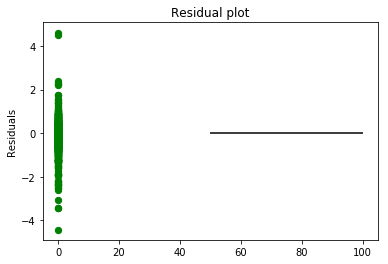

In [24]:
plt.scatter(y_pred_lm1, y_pred_lm1 - y_test, c='g', s=40)
plt.hlines(y=0, xmin=50, xmax=100)
plt.title("Residual plot")
plt.ylabel('Residuals')

# Model 2 -- land_tax_val

In [25]:
lm2, r2_lm2, y_pred_lm2 = create_univariate_linear_regression_model(X_train, y_train, features=['land_tax_val'])


Univariate - log error = b + m1 * square feet
    y-intercept  (b): 0.01
    coefficient (m1): -0.02
    Mean squared error of linear model is 0.02
    0.02% of the variance in the logerror of the train data can be explained by the number of rooms and the total square footage.


In [26]:
# pd.DataFrame({'actual': y_train.logerror,
#               'lm2': y_pred_lm2.ravel()})\
#     .melt(id_vars=['actual'], var_name='model', value_name='prediction')\
#     .pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')

# plt.plot([60, 100], [60, 100], c='black', ls=':')
# plt.ylim(60, 100)
# plt.xlim(60, 100)
# plt.title('Predicted vs Actual Log Error')
# # The further away from this line the are, the farther off the prediction was.

In [27]:
# Make predictions using the testing set
y_pred_lm2 = lm2.predict(X_test[['land_tax_val']])
mse = mean_squared_error(y_test, y_pred_lm2)
print(f'Mean Squared Error of linear model on test data: {mse}')

Mean Squared Error of linear model on test data: 0.02845459364092511


In [28]:
r2 = r2_score(y_test, y_pred_lm2)
print('{:.2%} of the variance in log errors in the test data can be explained by land_tax_val.'.format(r2))

0.01% of the variance in log errors in the test data can be explained by land_tax_val.


Text(0, 0.5, 'Residuals')

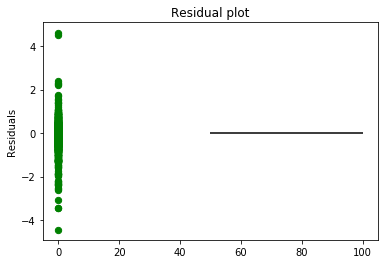

In [29]:
plt.scatter(y_pred_lm2, y_pred_lm2 - y_test, c='g', s=40)
plt.hlines(y=0, xmin=50, xmax=100)
plt.title("Residual plot")
plt.ylabel('Residuals')

# Models using cluster targets
    - cluster_target_A = logerror only
    - cluster_target_B = totsqft only
    - cluster_target_C = land_tax_val only
    - cluster_target_D = latitude, longitude, and totsqft

# Model 3 -- cluster_target_A

In [30]:
lm3, r2_lm3, y_pred_lm3 = create_univariate_linear_regression_model(X_train, y_train, features=['cluster_target_A'])


Univariate - log error = b + m1 * square feet
    y-intercept  (b): -0.00
    coefficient (m1): 0.01
    Mean squared error of linear model is 0.02
    0.24% of the variance in the logerror of the train data can be explained by the number of rooms and the total square footage.


In [31]:
# Make predictions using the testing set
y_pred_lm3 = lm3.predict(X_test[['cluster_target_A']])
mse = mean_squared_error(y_test, y_pred_lm3)
print(f'Mean Squared Error of test data: {mse}')

Mean Squared Error of test data: 0.02839413132152262


In [32]:
r2 = r2_score(y_test, y_pred_lm3)
print('{:.2%} of the variance in log errors in test data can be explained by cluster target A only.'.format(r2))

0.22% of the variance in log errors in test data can be explained by cluster target A only.


Text(0, 0.5, 'Residuals')

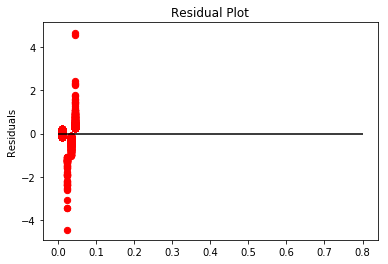

In [33]:
plt.scatter(y_pred_lm3, y_pred_lm3 - y_test, c='r', s=40)
plt.hlines(y=0, xmin=0, xmax=.8)
plt.title("Residual Plot")
plt.ylabel('Residuals')

# Model 4 -- cluster_target_A and cluster_target_B

In [34]:
lm4, r2_lm4, y_pred_lm4 = create_univariate_linear_regression_model(X_train, y_train, features=['cluster_target_A', 'cluster_target_B'])


Univariate - log error = b + m1 * square feet
    y-intercept  (b): -0.01
    coefficient (m1): 0.01
    Mean squared error of linear model is 0.02
    0.35% of the variance in the logerror of the train data can be explained by the number of rooms and the total square footage.


In [35]:
# Make predictions using the testing set
y_pred_lm4 = lm4.predict(X_test[['cluster_target_A', 'cluster_target_B']])
mse = mean_squared_error(y_test, y_pred_lm4)
print(f'Mean Squared Error of test data: {mse}')

Mean Squared Error of test data: 0.028353063274384346


In [36]:
r2 = r2_score(y_test, y_pred_lm4)
print('{:.2%} of the variance in log errors in test data can be explained by cluster targets A and B.'.format(r2))

0.37% of the variance in log errors in test data can be explained by cluster targets A and B.


Text(0, 0.5, 'Residuals')

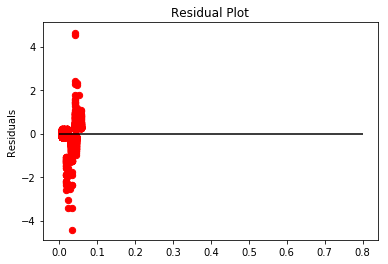

In [37]:
plt.scatter(y_pred_lm4, y_pred_lm4 - y_test, c='r', s=40)
plt.hlines(y=0, xmin=0, xmax=.8)
plt.title("Residual Plot")
plt.ylabel('Residuals')

# Model 5 -- cluster_target_A, cluster_target_B, and cluster_target_C

In [38]:
lm5, r2_lm5, y_pred_lm5 = create_univariate_linear_regression_model(X_train, y_train, features=['cluster_target_A', 'cluster_target_B', 'cluster_target_C'])


Univariate - log error = b + m1 * square feet
    y-intercept  (b): -0.00
    coefficient (m1): 0.01
    Mean squared error of linear model is 0.02
    0.41% of the variance in the logerror of the train data can be explained by the number of rooms and the total square footage.


In [39]:
# Make predictions using the testing set
y_pred_lm5 = lm5.predict(X_test[['cluster_target_A', 'cluster_target_B', 'cluster_target_C']])
mse = mean_squared_error(y_test, y_pred_lm5)
print(f'Mean Squared Error of test data: {mse}')

Mean Squared Error of test data: 0.02833901251567777


In [40]:
r2 = r2_score(y_test, y_pred_lm5)
print('{:.2%} of the variance in log errors in test data can be explained by cluster targets A, B, and C.'.format(r2))

0.42% of the variance in log errors in test data can be explained by cluster targets A, B, and C.


Text(0, 0.5, 'Residuals')

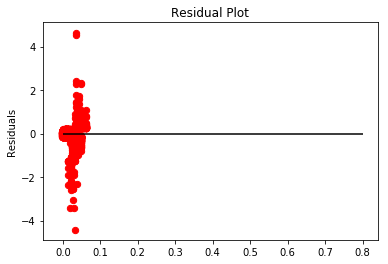

In [41]:
plt.scatter(y_pred_lm5, y_pred_lm5 - y_test, c='r', s=40)
plt.hlines(y=0, xmin=0, xmax=.8)
plt.title("Residual Plot")
plt.ylabel('Residuals')

# Model 6 -- cluster_target_A, cluster_target_B, cluster_target_C, and cluster_target_D

In [42]:
lm6, r2_lm6, y_pred_lm6 = create_univariate_linear_regression_model(X_train, y_train, features=['cluster_target_A', 'cluster_target_B', 'cluster_target_C', 'cluster_target_D'])


Univariate - log error = b + m1 * square feet
    y-intercept  (b): 0.00
    coefficient (m1): 0.01
    Mean squared error of linear model is 0.02
    0.45% of the variance in the logerror of the train data can be explained by the number of rooms and the total square footage.


In [43]:
# Make predictions using the testing set
y_pred_lm6 = lm6.predict(X_test[['cluster_target_A', 'cluster_target_B', 'cluster_target_C', 'cluster_target_D']])
mse = mean_squared_error(y_test, y_pred_lm6)
print(f'Mean Squared Error of test data: {mse}')

Mean Squared Error of test data: 0.028326148435717034


In [44]:
r2 = r2_score(y_test, y_pred_lm6)
print('{:.2%} of the variance in log errors in test data can be explained by cluster targets A, B, C, and D.'.format(r2))

0.46% of the variance in log errors in test data can be explained by cluster targets A, B, C, and D.


Text(0, 0.5, 'Residuals')

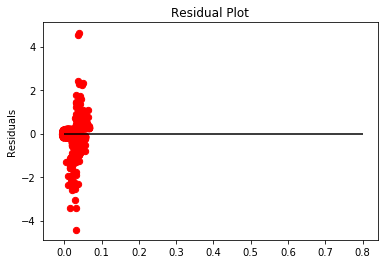

In [45]:
plt.scatter(y_pred_lm6, y_pred_lm6 - y_test, c='r', s=40)
plt.hlines(y=0, xmin=0, xmax=.8)
plt.title("Residual Plot")
plt.ylabel('Residuals')

# Model 7 -- cluster_target_D

In [46]:
lm7, r2_lm7, y_pred_lm7 = create_univariate_linear_regression_model(X_train, y_train, features=['cluster_target_D'])


Univariate - log error = b + m1 * square feet
    y-intercept  (b): 0.02
    coefficient (m1): -0.00
    Mean squared error of linear model is 0.02
    0.03% of the variance in the logerror of the train data can be explained by the number of rooms and the total square footage.


In [47]:
# Make predictions using the testing set
y_pred_lm7 = lm7.predict(X_test[['cluster_target_D']])
mse = mean_squared_error(y_test, y_pred_lm7)
print(f'Mean Squared Error of test data: {mse}')

Mean Squared Error of test data: 0.028451164409519256


In [48]:
r2 = r2_score(y_test, y_pred_lm7)
print('{:.2%} of the variance in log errors in test data can be explained by cluster targets D.'.format(r2))

0.02% of the variance in log errors in test data can be explained by cluster targets D.


Text(0, 0.5, 'Residuals')

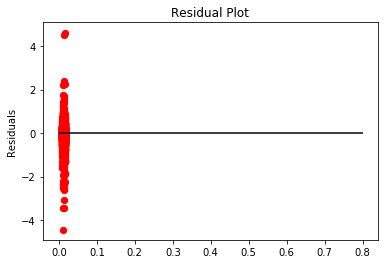

In [49]:
plt.scatter(y_pred_lm7, y_pred_lm7 - y_test, c='r', s=40)
plt.hlines(y=0, xmin=0, xmax=.8)
plt.title("Residual Plot")
plt.ylabel('Residuals')

# Model 8 -- cluster_target_A, cluster_target_B, and cluster_target_E

In [50]:
lm8, r2_lm8, y_pred_lm8 = create_univariate_linear_regression_model(
    X_train, 
    y_train, 
    features=['cluster_target_A', 'cluster_target_B', 'cluster_target_E'])


Univariate - log error = b + m1 * square feet
    y-intercept  (b): -0.02
    coefficient (m1): 0.01
    Mean squared error of linear model is 0.02
    0.36% of the variance in the logerror of the train data can be explained by the number of rooms and the total square footage.


In [51]:
# Make predictions using the testing set
y_pred_lm8 = lm8.predict(X_test[['cluster_target_A', 'cluster_target_B', 'cluster_target_E']])
mse = mean_squared_error(y_test, y_pred_lm6)
print(f'Mean Squared Error of test data: {mse}')

Mean Squared Error of test data: 0.028326148435717034


In [52]:
r2 = r2_score(y_test, y_pred_lm6)
print('{:.2%} of the variance in log errors in test data can be explained by cluster targets A, B, and E.'.format(r2))

0.46% of the variance in log errors in test data can be explained by cluster targets A, B, and E.


Text(0, 0.5, 'Residuals')

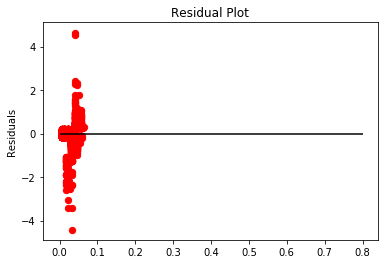

In [53]:
plt.scatter(y_pred_lm8, y_pred_lm8 - y_test, c='r', s=40)
plt.hlines(y=0, xmin=0, xmax=.8)
plt.title("Residual Plot")
plt.ylabel('Residuals')

# Try one on a poloynomial regression...

In [ ]:
lm9, r2_lm9, y_pred_lm9 = model_polyreg(X_train, 
                                        y_train, 
                                        features=['cluster_target_A', 'cluster_target_B', 'cluster_target_E'])

In [ ]:
# Make predictions using the testing set
y_pred_lm9 = lm9.predict(X_test[['cluster_target_A', 'cluster_target_B', 'cluster_target_E']])
mse = mean_squared_error(y_test, y_pred_lm9)
print(f'Mean Squared Error of test data: {mse}')

In [ ]:
r2 = r2_score(y_test, y_pred_lm9)
print('{:.2%} of the variance in log errors in test data can be explained by cluster targets A, B, and E.'.format(r2))

In [ ]:
plt.scatter(y_pred_lm9, y_pred_lm9 - y_test, c='r', s=40)
plt.hlines(y=0, xmin=0, xmax=.8)
plt.title("Residual Plot")
plt.ylabel('Residuals')